<h1 align="center">홍수기간 댐 유입량 예측</h1>

1. [Introduction](#1) <a id=20></a>
    - 1.1 [Data Dictionary](#2)
    - 1.2 [Task](#3)
2. [Preparation](#4)
    - 2.1 [Packages](#5)
    - 2.2 [Data](#6)
    - 2.3 [Understanding Data](#7)
3. [Exploratory Data Analysis](#8)
    - 3.1 [Correlation](#9)
    - 3.2 [EDA graph](#10)
4. [Data Preprocessing](#11)
    - 4.1 [Conclusions from the EDA](#12)
    - 4.2 [Packages for Modeling](#13)
    - 4.3 [Making features model ready](#14)
    - 4.4 [Train/Test Split](#15)
5. [Modeling](#16)
    - 5.1 [Basic Model](#17)
    - 5.2 [Ensemble Model](#18)
6. [Predicting the 26th Event](#19)

### 1. Introduction <a id=1></a>
[back to top](#20)

#### 1.1 Data Dictionary <a id=2></a>
- 홍수사상번호 : 강우가 상대적으로 커 토양/지반이 포화된 후 댐으로 많은 양의 유량이 흘러 들어온 기간
- 연/월/일/시간 : 해당 유입량을 측정한 날짜와 시간
- 유입량 : K-댐에 흘러 들어오는 유량 
- 데이터집단 1~6 : 종속변수와 상관성이 높은 데이터 집단(성격- 강우/수위관측소-댐구간거리/시간 등을 달리 설정하여 얻은 독립변수 집단)
   - 유역평균강수 :강수량이 모이는 모든 지역의 평균 강우량(A,B,C,D,E 지역 평균 강수)
   - 강우(A지역) : A지역의 비가 온 양을 계측
   - 강우(B지역) : B지역의 비가 온 양을 계측
   - 강우(C지역) : C지역의 비가 온 양을 계측
   - 강우(D지역) : D지역의 비가 온 양을 계측
   - 수위(E지역) : E지역의 물의 높이를 계측
   - 수위(D지역) : D지역의 물의 높이를 계측
   

#### 1.2 Task <a id=3></a>
최근 10년간 발생했던 홍수사상(총 25개)을 대상으로 유입량에 영향을 미치는 관측소의 강우량 및 수위 데이터를 학습하여 홍수사상 26의 댐 유입 수량을 예측

### 2. Preparation <a id=4></a>
[back to top](#20)

#### 2.1 Packages <a id=5></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### 2.2 Data <a id=6></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename= '/content/drive/MyDrive/빅콘테스트/data set/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx'

# double column의 문제 해결을 위해 raw data 형식 변경
raw = pd.read_excel(filename,header=[0,1],index_col=[0,1,2,3,4,5])
raw = raw.stack(level=0)
raw = raw.reset_index()

# 코딩 시 편하도록 변수명 영어로 변경
raw.columns = ['event', 'year', 'month', 'day', 'time', 'target', 'group',  'rainA', 'rainB', 'rainC', 'rainD', 'levelD', 'levelE','avg_rain']
raw = raw[['event', 'year', 'month', 'day', 'time', 'target',  'group', 'avg_rain',  'rainA', 'rainB', 'rainC', 'rainD', 'levelE', 'levelD']]

#### 2.3 Understanding Data <a id=7></a>

##### 2.3.1 The shape of the data

In [ ]:
print("The shape of the raw dataset is", raw.shape)

The shape of the raw dataset is (18306, 14)


##### 2.3.2 Preview of the first 5 rows of the data

In [ ]:
raw.head()

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD
0,1,2006,7,10,8,189.1,데이터집단 1,6.4,7,7,7,8,2.54,122.568750
1,1,2006,7,10,8,189.1,데이터집단 2,6.3,7,7,7,8,2.54,122.541667
2,1,2006,7,10,8,189.1,데이터집단 3,6.3,7,7,7,8,2.54,122.550000
3,1,2006,7,10,8,189.1,데이터집단 4,6.4,7,7,8,8,2.54,122.675000
4,1,2006,7,10,8,189.1,데이터집단 5,6.4,7,7,8,8,2.54,122.660000


##### 2.3.3 Missing values

In [ ]:
raw.isnull().sum()

event       0
year        0
month       0
day         0
time        0
target      0
group       0
avg_rain    0
rainA       0
rainB       0
rainC       0
rainD       0
levelE      0
levelD      0
dtype: int64

=> 완벽하게 채워졌음을 확인

##### 2.3.4 Removing the Evaluation Dataset

In [ ]:
raw_26 = raw.loc[raw[raw['event'] == 26].index]  #test set 생성 26번 사상
raw = raw.loc[raw[raw['event'] != 26].index] # train set 생성 26번 사상 제거 
print("The shape of the raw1~25 dataset is", raw.shape)
print("The shape of the raw26 dataset is", raw_26.shape)

The shape of the raw1~25 dataset is (17346, 14)
The shape of the raw26 dataset is (960, 14)


In [ ]:
# 복사본도 저장해두기
raw_origin=raw.copy()

### 3. Exploratory Data Analysis <a id=8></a>
[back to top](#20)

#### 3.1 Correlation <a id=9></a>

In [ ]:
raw_conti=raw[['target','avg_rain','rainA','rainB','rainC','rainD','levelE','levelD']]
raw_conti.tail()

,target,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD
17341,470.458109,2.7514,1,0,1,1,2.94,137.208333
17342,470.458109,2.7514,1,0,1,1,2.94,137.216667
17343,470.458109,2.1142,1,0,1,1,2.94,137.121429
17344,470.458109,1.7908,1,0,1,1,2.94,137.152000
17345,470.458109,1.7366,1,0,1,1,2.94,137.180000


In [ ]:
# correlation
raw_conti_corr=raw_conti.corr()
raw_conti_corr

,target,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD
target,1.000000,0.759771,0.613778,0.759119,0.624002,0.713868,0.903840,0.106671
avg_rain,0.759771,1.000000,0.817295,0.940906,0.825614,0.830387,0.821468,0.048375
rainA,0.613778,0.817295,1.000000,0.791938,0.550060,0.606000,0.723681,-0.143660
rainB,0.759119,0.940906,0.791938,1.000000,0.754337,0.795002,0.792505,-0.013549
rainC,0.624002,0.825614,0.550060,0.754337,1.000000,0.818118,0.666869,0.041408
rainD,0.713868,0.830387,0.606000,0.795002,0.818118,1.000000,0.765963,0.065780
levelE,0.903840,0.821468,0.723681,0.792505,0.666869,0.765963,1.000000,0.145923
levelD,0.106671,0.048375,-0.143660,-0.013549,0.041408,0.065780,0.145923,1.000000


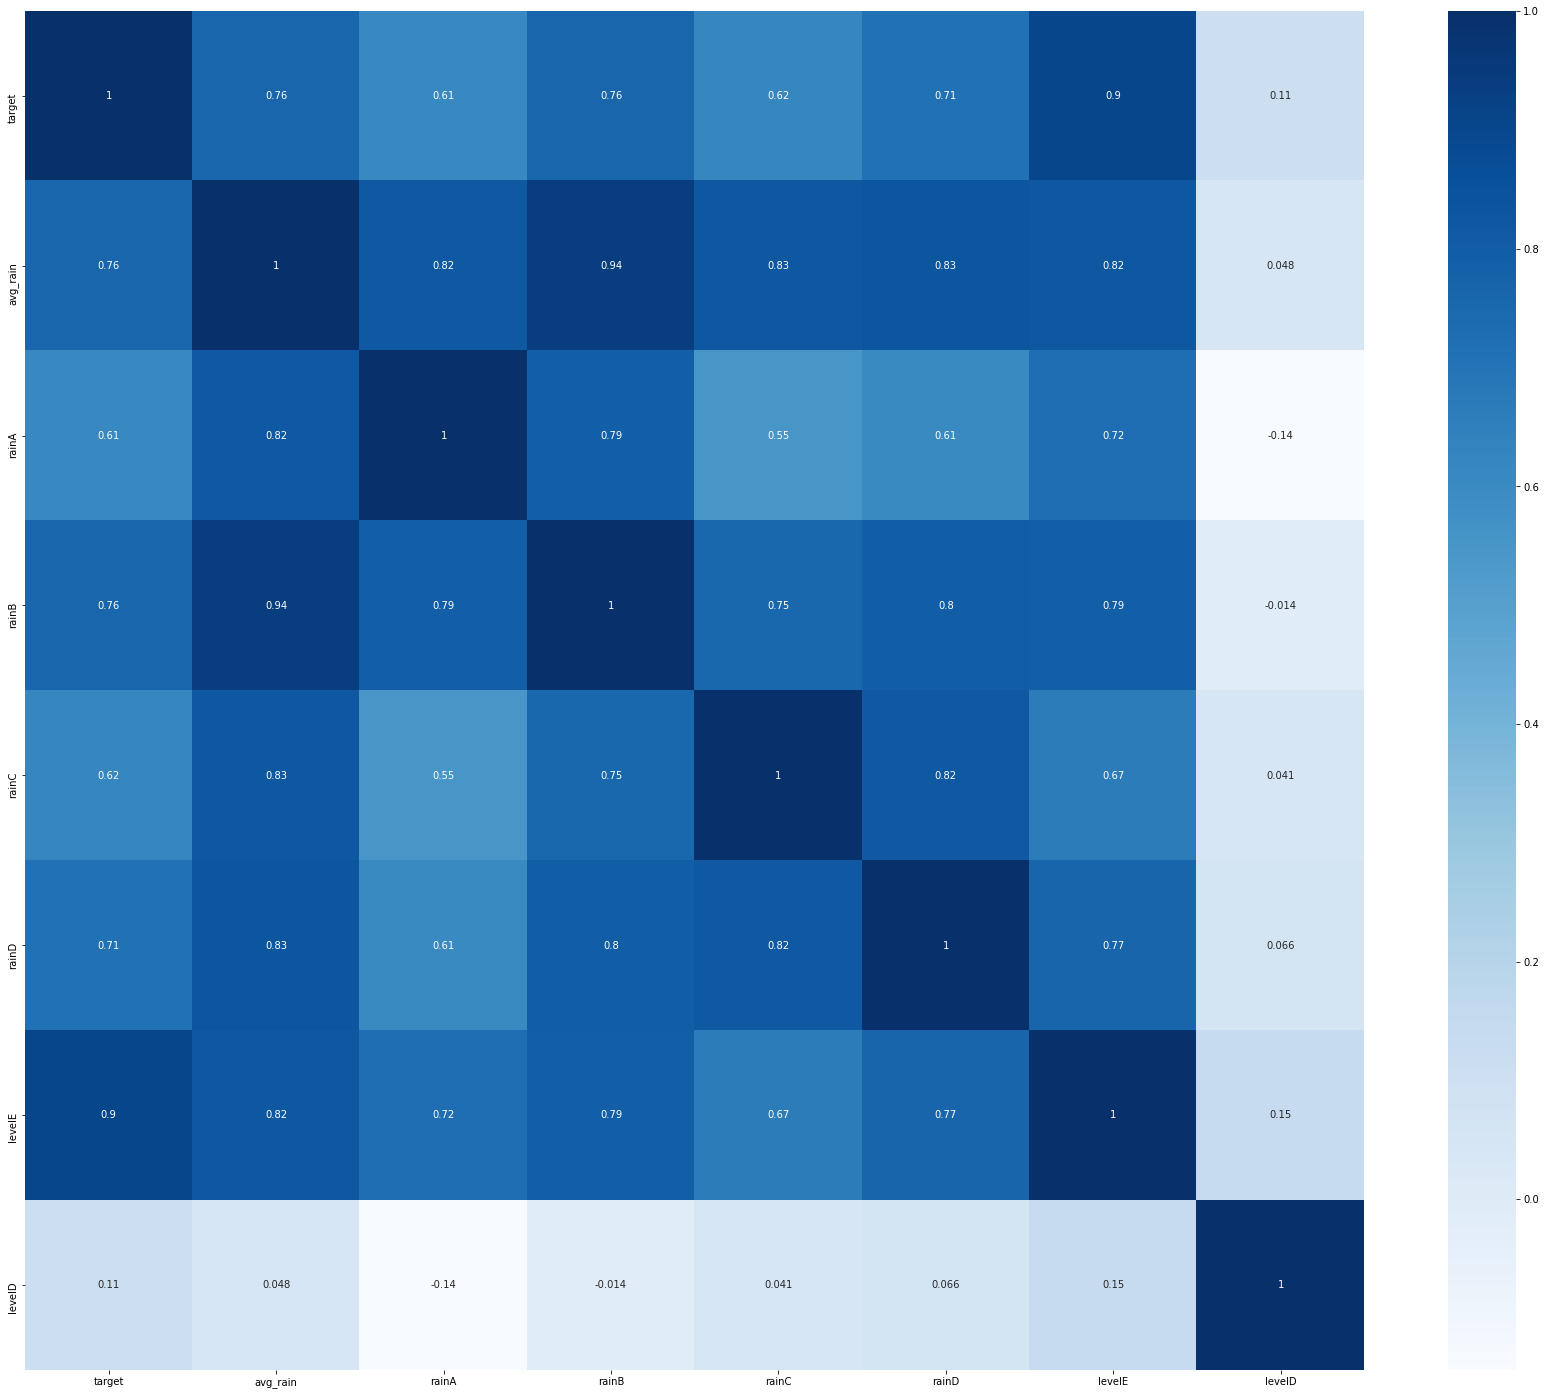

In [ ]:
# heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(raw_conti_corr,cmap='Blues', annot=True)

In [ ]:
# pairplot
sns.pairplot(raw)

Output hidden; open in https://colab.research.google.com to view.

#### 3.2 EDA graph <a id=10></a>
R 결과 첨부 (데이터분석분야_퓨처스리그_홍수ZERO_옥수수팀_프로그램코딩자료_EDA(R코드)참고)


### 4. Data Preprocessing <a id=11></a>
[back to top](#20)

#### 4.1 Conclusions from the EDA <a id=12></a>

1. 시계열성을 고려하여 LSTM 진행
2. 독립으로 간주하여 진행

#### 4.2 Packages for Modeling <a id=13></a>

In [ ]:
# 전처리
from sklearn.preprocessing import StandardScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgbm
from lightgbm.sklearn import LGBMRegressor
import sklearn
from sklearn.ensemble import *
from sklearn.metrics import *

# Cross Validation
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

# 평가 지표
from sklearn.metrics import mean_squared_error

print('Packages imported...')

Packages imported...


#### 4.3 Making features model ready <a id=14></a>

##### 4.3.1 Scaling  features

In [ ]:
raw1=pd.read_csv("/content/drive/MyDrive/빅콘테스트/data set/bigcon_raw_version2.csv")

In [ ]:
scaler = StandardScaler()
x = raw1.drop('target',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('event',axis=1).drop('year',axis=1).values # 독립변인들의 value값만 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

features = ['avg_rain_g1','rainA_g1', 'rainB_g1', 'rainC_g1', 'rainD_g1', 'levelE_g1', 'levelD_g1', 'avg_rain_g2', 'rainA_g2', 'rainB_g2', 'rainC_g2','rainD_g2', 'levelE_g2', 'levelD_g2', 'avg_rain_g3', 'rainA_g3', 'rainB_g3', 'rainC_g3', 'rainD_g3', 'levelE_g3', 'levelD_g3', 'avg_rain_g4', 'rainA_g4', 'rainB_g4', 'rainC_g4', 'rainD_g4', 'levelE_g4', 'levelD_g4', 'avg_rain_g5', 'rainA_g5', 'rainB_g5', 'rainC_g5', 'rainD_g5', 'levelE_g5', 'levelD_g5', 'avg_rain_g6','rainA_g6', 'rainB_g6', 'rainC_g6', 'rainD_g6', 'levelE_g6', 'levelD_g6']
data=pd.DataFrame(x,columns=features)
data
data.to_excel(excel_writer='/content/drive/MyDrive/빅콘테스트/data set/scaleversion.xlsx')

In [ ]:
raw2=pd.read_excel('/content/drive/MyDrive/빅콘테스트/data set/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803_scaled.xlsx',header=[0,1],index_col=[0,1,2,3,4,5])

In [ ]:
raw2 = raw2.stack(level=0)
raw2 = raw2.reset_index()
raw2.columns = ['event', 'year', 'month', 'day', 'time', 'target',  'group',  'rainA', 'rainB', 'rainC', 'rainD', 'levelD', 'levelE','avg_rain']
raw2 = raw2[['event', 'year', 'month', 'day', 'time', 'target',  'group', 'avg_rain',  'rainA', 'rainB', 'rainC', 'rainD', 'levelE', 'levelD']]

In [ ]:
raw2.to_excel(excel_writer='/content/drive/MyDrive/빅콘테스트/data set/raw_data_scaled.xlsx') #standard scaled data_데이터 집단을 column으로

In [ ]:
#1.raw 생성
# 새로운 데이터 파일 불러오기
filename2 = '/content/drive/MyDrive/빅콘테스트/data set/raw_data_scaled.xlsx' #standard scaled data_데이터 집단을 column으로
raw_data = pd.read_excel(filename2)
raw_data = raw_data.drop('Unnamed: 0',1)
raw_data.head()

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD
0,1,2006,7,10,8,189.1,데이터집단 1,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,-1.480285
1,1,2006,7,10,8,189.1,데이터집단 2,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,-1.496876
2,1,2006,7,10,8,189.1,데이터집단 3,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,-1.502692
3,1,2006,7,10,8,189.1,데이터집단 4,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,-1.438455
4,1,2006,7,10,8,189.1,데이터집단 5,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,-1.447915


standard scaled data_데이터 집단을 column으로

In [ ]:
raw_raw_26 = raw_data.loc[raw_data[raw_data['event'] == 26].index] #test set 생성 26번 사상
raw = raw_data.loc[raw_data[raw_data['event'] != 26].index] # train set 생성 26번 사상 제거 
raw.shape

(17346, 14)

##### 4.3.2 New Features

levelD lag_data 생성 (raw_data_scaled_levelD_d) - R 데이터분석분야_퓨처스리그_홍수ZERO_옥수수팀_프로그램코딩자료_levelD_lag 데이터 생성(R코드) 참조

*   항목 추가
*   항목 추가




In [ ]:
#2. raw_d 생성
filename3 = '/content/drive/MyDrive/빅콘테스트/data set/raw_data_scaled_levelD_d.csv' #standard scaled data_데이터 집단을 column으로
raw_data_d = pd.read_csv(filename3)
raw_data_d = raw_data_d.drop('Unnamed: 0',1)
raw_data_d.head(12)

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
0,1,2006,7,10,8,189.100000,데이터집단 1,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,0.000000
1,1,2006,7,10,8,189.100000,데이터집단 2,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,0.000000
2,1,2006,7,10,8,189.100000,데이터집단 3,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,0.000000
3,1,2006,7,10,8,189.100000,데이터집단 4,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
4,1,2006,7,10,8,189.100000,데이터집단 5,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
5,1,2006,7,10,8,189.100000,데이터집단 6,-0.989485,-1.032332,-0.850690,-0.690847,-0.819482,-0.852782,0.000000
6,1,2006,7,10,9,216.951962,데이터집단 1,-1.038559,-0.988808,-0.889561,-0.712134,-0.808934,-0.856992,-0.001031
7,1,2006,7,10,9,216.951962,데이터집단 2,-1.045777,-1.017853,-0.882157,-0.708746,-0.808934,-0.856992,0.001375
8,1,2006,7,10,9,216.951962,데이터집단 3,-1.045777,-1.017853,-0.825489,-0.714176,-0.815826,-0.856992,0.001376
9,1,2006,7,10,9,216.951962,데이터집단 4,-1.039556,-1.032332,-0.825489,-0.789880,-0.804437,-0.856992,-0.001181


In [ ]:
raw_26_d = raw_data_d.loc[raw_data_d[raw_data_d['event'] == 26].index] #test set 생성 26번 사상
raw_d = raw_data_d.loc[raw_data_d[raw_data_d['event'] != 26].index] # train set 생성 26번 사상 제거 
raw_d.shape

(17346, 14)

In [ ]:
raw_d

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
0,1,2006,7,10,8,189.100000,데이터집단 1,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,0.000000
1,1,2006,7,10,8,189.100000,데이터집단 2,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,0.000000
2,1,2006,7,10,8,189.100000,데이터집단 3,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,0.000000
3,1,2006,7,10,8,189.100000,데이터집단 4,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
4,1,2006,7,10,8,189.100000,데이터집단 5,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17341,25,2017,7,18,22,470.458109,데이터집단 2,-1.107299,-1.100140,-1.009351,-0.840654,-0.933227,-0.684352,0.001375
17342,25,2017,7,18,22,470.458109,데이터집단 3,-1.107299,-1.100140,-0.959722,-0.846178,-0.940087,-0.684352,0.001376
17343,25,2017,7,18,22,470.458109,데이터집단 4,-1.127078,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002952
17344,25,2017,7,18,22,470.458109,데이터집단 5,-1.118400,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002643


##### 4.3.3 PCA

1. raw - pca(n=2)가 적당 

In [ ]:
# 피쳐 규정
x= raw.drop('target',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('event',axis=1).drop('year',axis=1).drop('group',axis=1)

# 종속변인 추출
y = raw['target'].values

In [ ]:
!  pip install plotly
import plotly.express as px

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes


pca = PCA()
pca.fit(x)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

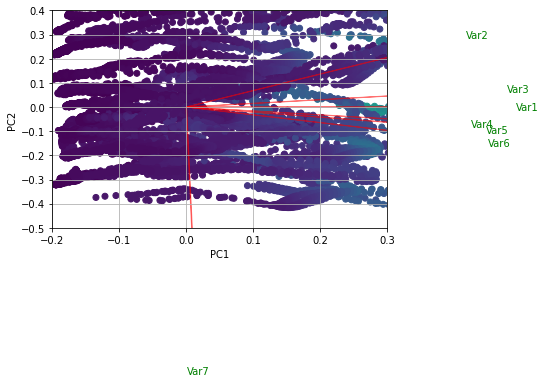

In [ ]:
pca = PCA()
x_new = pca.fit_transform(x)


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.2,0.3)
    plt.ylim(-0.5,0.4)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

2. raw_d - pca(n=3) 적당 

In [ ]:
# 피쳐 규정
x = raw_d.drop('target',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('event',axis=1).drop('year',axis=1).drop('group',axis=1)

# 종속변인 추출
y = raw_d['target'].values

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes


pca = PCA()
pca.fit(x)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

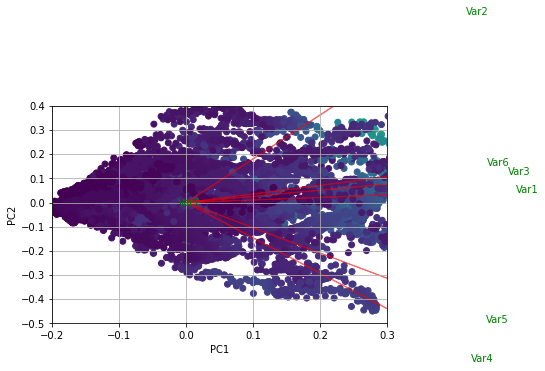

In [ ]:
pca = PCA()
x_new = pca.fit_transform(x)


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.2,0.3)
    plt.ylim(-0.5,0.4)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

#### 4.4 Train/Test Split <a id=15></a>

최종 Data Set
1. raw_data_scaled --> raw
2. raw_data_scaled_levelD_d --> raw_data_d

-> 각각 Train/Test 4:1로 split (test_size=0.2, random_state=30)


In [ ]:
from sklearn.model_selection import train_test_split

##### 4.4.1 Dataset Combination
9개의 데이터셋을 구성해 같은 모델들을 돌려본 결과, 최적 성능 도출에 도움이 되었던 데이터셋만 규정
- 집단별 1~6 --> df_1 ~ df_6
- max --> df_7
- max --> df_8
- 전체 --> df_9

In [ ]:
df_9 = raw.drop('group',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('year',axis=1)
df_9

,event,target,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD
0,1,189.100000,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,-1.480285
1,1,189.100000,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,-1.496876
2,1,189.100000,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,-1.502692
3,1,189.100000,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,-1.438455
4,1,189.100000,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,-1.447915
...,...,...,...,...,...,...,...,...,...
17341,25,470.458109,-1.107299,-1.100140,-1.009351,-0.840654,-0.933227,-0.684352,0.923732
17342,25,470.458109,-1.107299,-1.100140,-0.959722,-0.846178,-0.940087,-0.684352,0.919531
17343,25,470.458109,-1.127078,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.949257
17344,25,470.458109,-1.118400,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.946110


### 5. Modeling <a id=16></a>
[back to top](#20)

In [ ]:
my_predictions = {}
my_pred = None
my_actual = None
my_name = None

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def rmse_eval(name_, pred, actual):
    global my_predictions, colors, my_pred, my_actual, my_name
    
    my_name = name_
    my_pred = pred
    my_actual = actual

    plot_predictions(name_, pred, actual)

    rmse = np.sqrt(mean_squared_error(pred, actual))
    my_predictions[name_] = rmse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'rmse'])
    print(df)
    min_ = df['rmse'].min() - 10
    max_ = df['rmse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['rmse'], height=0.3)
    
    for i, v in enumerate(df['rmse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 1, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('RMSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()
    
def add_model(name_, pred, actual):
    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    rmse = mean_squared_error(pred, actual)
    my_predictions[name_] = rmse

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_all():
    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'rmse'])
    print(df)
    min_ = df['rmse'].min() - 10
    max_ = df['rmse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['rmse'], height=0.3)
    
    for i, v in enumerate(df['rmse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 1, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('RMSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

#### 5.1 Basic Model <a id=17></a>

1.   항목 추가

1.   항목 추가
2.   항목 추가


2.   항목 추가


RMSE값이 낮은 모델 3개 선정 - DecisionTree, XGboost, LightGBM

In [ ]:
SEED = 30

In [ ]:
from sklearn.model_selection import cross_val_score,GroupKFold,KFold
gkf=GroupKFold(n_splits=5)

In [ ]:
X=df_9.drop("target",axis=1).drop('event',axis=1)
y=df_9["target"]

x_train, x_test, y_train, y_test = train_test_split(df_9.drop('target', 1).drop('event', 1), df_9['target'], test_size=0.2, random_state=SEED)

In [ ]:
event=df_9.iloc[:,0]

best parameter : DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


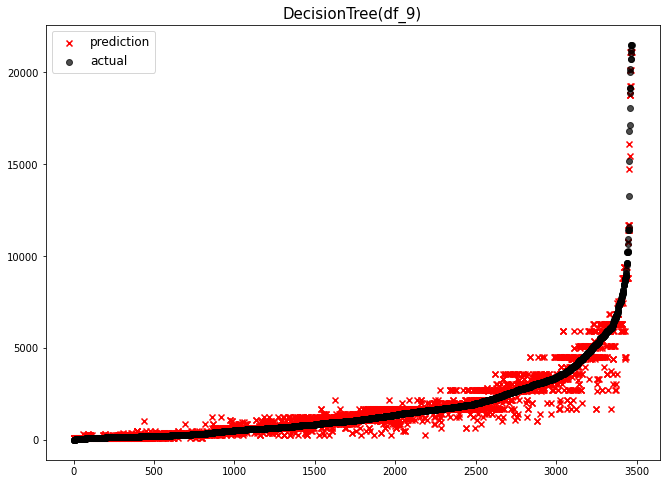

                model       rmse
0  DecisionTree(df_9)  491.23682


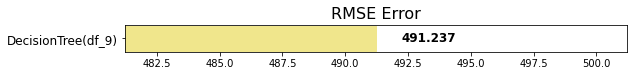

In [ ]:
dt=DecisionTreeRegressor()
param_grid = {"min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9],
              "max_depth":[2, 3, 4, 5, 6, None],
              "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs=GridSearchCV(DecisionTreeRegressor(),param_grid=param_grid,cv=gkf.split(X,y, groups=event),scoring="neg_root_mean_squared_error")
gs.fit(X,y)
dt=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

dt.fit(x_train, y_train)
pred = dt.predict(x_test)
rmse_eval('DecisionTree(df_9)', pred, y_test)


[05:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

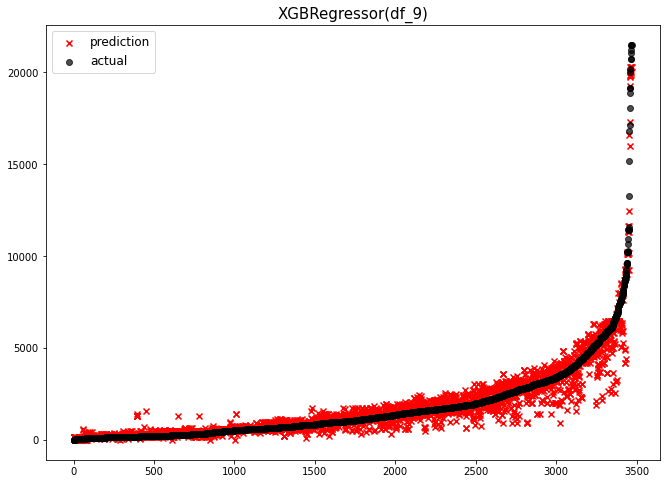

                model        rmse
0  XGBRegressor(df_9)  508.802157
1  DecisionTree(df_9)  491.236820


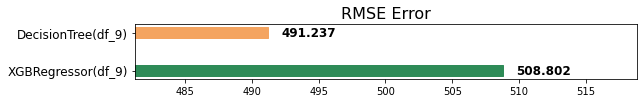

In [ ]:
xgb=XGBRegressor(random_state=30)
param_grid =  {"n_estimators": [200, 300, 500],
                "learning-rate": [0.1,0.2,0.3],
                "max_depth": [1, 2, 3]}
gs=GridSearchCV(XGBRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),verbose=0,scoring="neg_root_mean_squared_error")
gs.fit(X,y)
xgb=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
rmse_eval('XGBRegressor(df_9)', pred, y_test)

best parameter : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning-rate=0.1, learning_rate=0.1,
              max_depth=1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iteration=200, num_leaves=31, objective=None, random_state=30,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


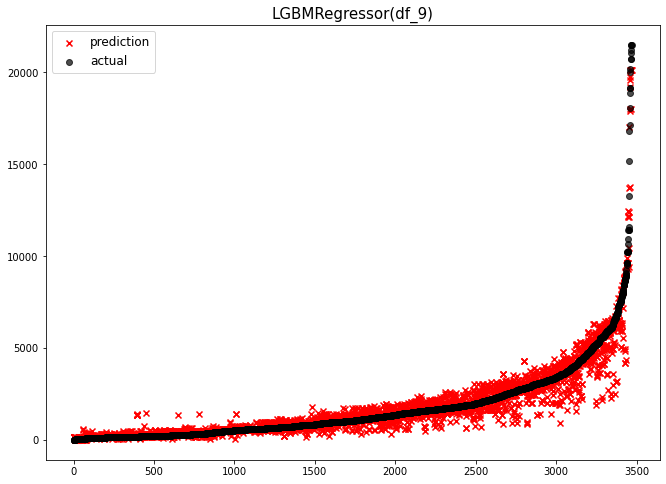

                 model        rmse
0  LGBMRegressor(df_9)  522.327673
1   XGBRegressor(df_9)  508.802157
2   DecisionTree(df_9)  491.236820


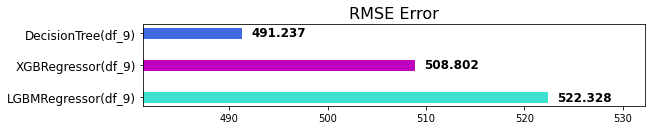

In [ ]:
lgbm=LGBMRegressor(random_state=30)
param_grid = {"num_iteration": [200, 300, 500],
              "learning-rate": [0.1,0.2,0.3],
              "max_depth": [1, 2, 3]}
gs=GridSearchCV(LGBMRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),scoring="neg_root_mean_squared_error")
gs.fit(X,y)
lgbm=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_test)
rmse_eval('LGBMRegressor(df_9)', pred, y_test)

#### 5.2 Ensemble Model <a id=18></a>

성능이 가장 좋은 DecisionTree 앙상블 모형 - RandomForest - 성능 향상

##### 5.2.1 raw data

best parameter : RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


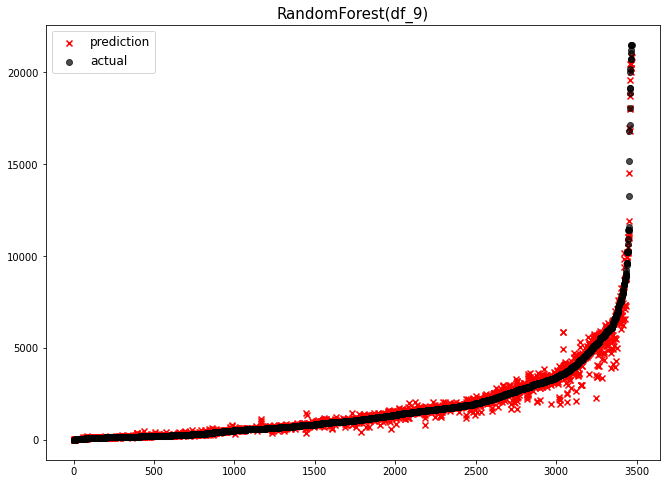

                 model        rmse
0  LGBMRegressor(df_9)  522.327673
1   XGBRegressor(df_9)  508.802157
2   DecisionTree(df_9)  491.236820
3   RandomForest(df_9)  265.917650


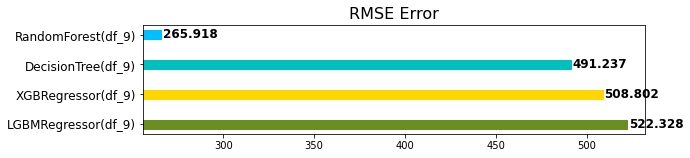

In [ ]:
rf=RandomForestRegressor(random_state=30)
param_grid = {"n_estimators": [200, 300, 500],
              "max_features": [4,9,16],
              "min_samples_leaf": [6, 8, 10]}

gs=GridSearchCV(RandomForestRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),n_jobs=-1,scoring="neg_root_mean_squared_error")
gs.fit(X,y)
rf=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

rf.fit(x_train, y_train)
pred1 = rf.predict(x_test)
rmse_eval('RandomForest(df_9)', pred1, y_test)

<function matplotlib.pyplot.show>

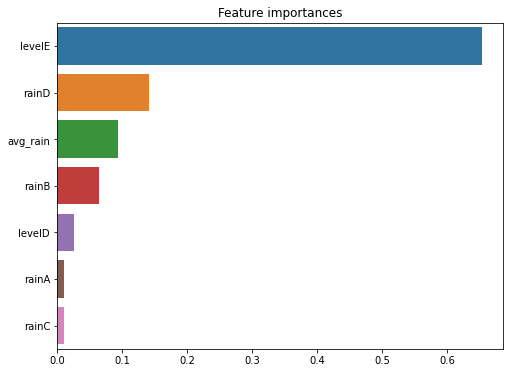

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show

##### 5.2.2 rainC 제거


In [ ]:
X=df_9.drop("target",axis=1).drop('event',axis=1).drop('rainC',1)
y=df_9["target"]

x_train, x_test, y_train, y_test = train_test_split(df_9.drop('target', 1).drop('event', 1).drop('rainC',1), df_9['target'], test_size=0.2, random_state=SEED)

In [ ]:
event=df_9.iloc[:,0]

best parameter : RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


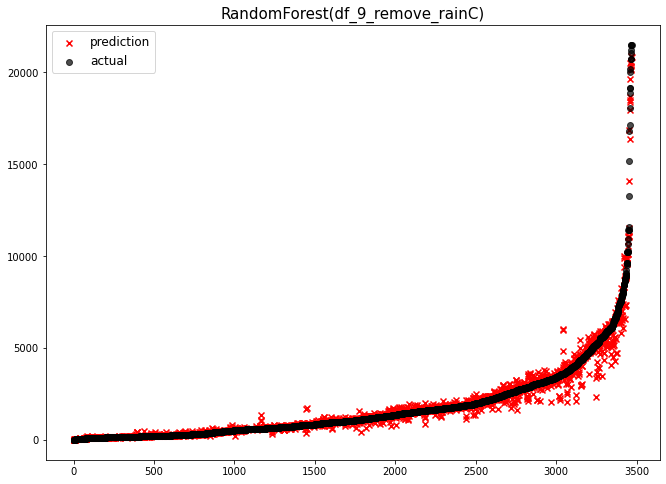

                             model        rmse
0              LGBMRegressor(df_9)  522.327673
1               XGBRegressor(df_9)  508.802157
2               DecisionTree(df_9)  491.236820
3               RandomForest(df_9)  265.917650
4  RandomForest(df_9_remove_rainC)  263.828026


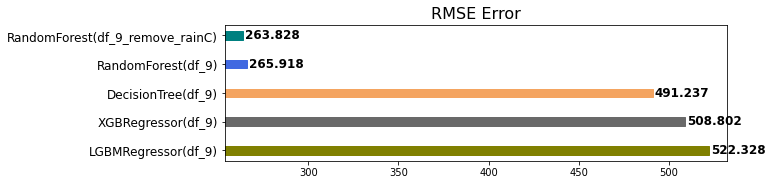

In [ ]:
rf_C=RandomForestRegressor(random_state=30)
param_grid = {"n_estimators": [200, 300, 500],
              "max_features": [4,9,16],
              "min_samples_leaf": [6, 8, 10]}

gs=GridSearchCV(RandomForestRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),n_jobs=-1,scoring="neg_root_mean_squared_error")
gs.fit(X,y)
rf_C=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

rf_C.fit(x_train, y_train)
pred2 = rf_C.predict(x_test)
rmse_eval('RandomForest(df_9_remove_rainC)', pred2, y_test)

##### 5.2.3 차분 levelD data - 최종선택모형

In [ ]:
raw_d

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
0,1,2006,7,10,8,189.100000,데이터집단 1,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,0.000000
1,1,2006,7,10,8,189.100000,데이터집단 2,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,0.000000
2,1,2006,7,10,8,189.100000,데이터집단 3,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,0.000000
3,1,2006,7,10,8,189.100000,데이터집단 4,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
4,1,2006,7,10,8,189.100000,데이터집단 5,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17341,25,2017,7,18,22,470.458109,데이터집단 2,-1.107299,-1.100140,-1.009351,-0.840654,-0.933227,-0.684352,0.001375
17342,25,2017,7,18,22,470.458109,데이터집단 3,-1.107299,-1.100140,-0.959722,-0.846178,-0.940087,-0.684352,0.001376
17343,25,2017,7,18,22,470.458109,데이터집단 4,-1.127078,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002952
17344,25,2017,7,18,22,470.458109,데이터집단 5,-1.118400,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002643


In [ ]:
df_9_d = raw_d.drop('group',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('year',axis=1)
df_9_d

,event,target,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
0,1,189.100000,-1.036874,-0.988808,-0.905344,-0.712134,-0.808934,-0.852782,0.000000
1,1,189.100000,-1.047463,-1.017853,-0.898056,-0.708746,-0.808934,-0.852782,0.000000
2,1,189.100000,-1.047463,-1.017853,-0.842268,-0.714176,-0.815826,-0.852782,0.000000
3,1,189.100000,-1.054745,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
4,1,189.100000,-1.039462,-1.032332,-0.842268,-0.828119,-0.839624,-0.852782,0.000000
...,...,...,...,...,...,...,...,...,...
17341,25,470.458109,-1.107299,-1.100140,-1.009351,-0.840654,-0.933227,-0.684352,0.001375
17342,25,470.458109,-1.107299,-1.100140,-0.959722,-0.846178,-0.940087,-0.684352,0.001376
17343,25,470.458109,-1.127078,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002952
17344,25,470.458109,-1.118400,-1.114051,-0.959722,-0.961952,-0.962778,-0.684352,0.002643


In [ ]:
X=df_9_d.drop("target",axis=1).drop('event',axis=1)
y=df_9_d["target"]

x_train, x_test, y_train, y_test = train_test_split(df_9_d.drop('target', 1).drop('event', 1), df_9_d['target'],test_size=0.2, random_state=SEED)

In [ ]:
event=df_9_d.iloc[:,0]

best parameter : RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


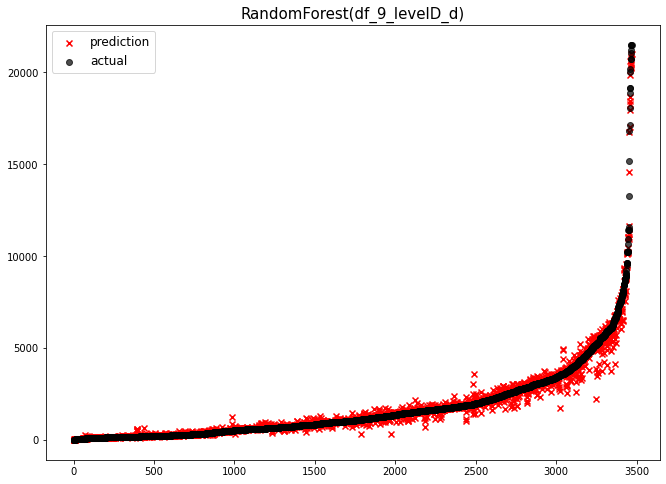

                             model        rmse
0              LGBMRegressor(df_9)  522.327673
1               XGBRegressor(df_9)  508.802157
2               DecisionTree(df_9)  491.236820
3               RandomForest(df_9)  265.917650
4  RandomForest(df_9_remove_rainC)  263.828026
5      RandomForest(df_9_levelD_d)  231.266744


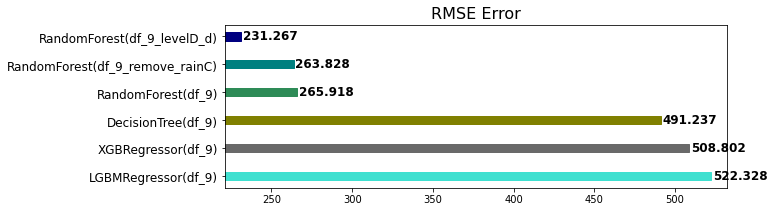

In [ ]:
rf_d=RandomForestRegressor(random_state=30)
param_grid = {"n_estimators": [200, 300, 500],
              "max_features": [4,9,16],
              "min_samples_leaf": [6, 8, 10]}

gs=GridSearchCV(RandomForestRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),n_jobs=-1,scoring="neg_root_mean_squared_error")
gs.fit(X,y)
rf_d=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

rf_d.fit(x_train, y_train)
pred = rf_d.predict(x_test)
rmse_eval('RandomForest(df_9_levelD_d)', pred, y_test)

##### 5.2.4 raw_d에서 rainC제거

In [ ]:
X=df_9_d.drop("target",axis=1).drop('event',axis=1).drop('rainC',1)
y=df_9_d["target"]

x_train, x_test, y_train, y_test = train_test_split(df_9_d.drop('target', 1).drop('event', 1), df_9_d['target'],test_size=0.2, random_state=SEED)

In [ ]:
event=df_9_d.iloc[:,0]

best parameter : RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


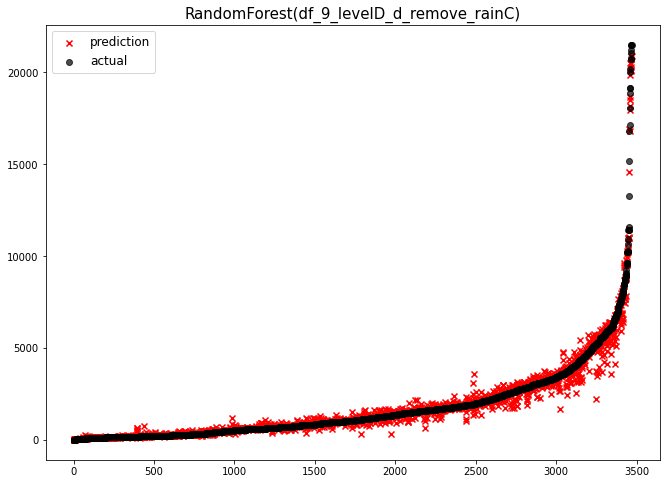

                                      model        rmse
0                       LGBMRegressor(df_9)  522.327673
1                        XGBRegressor(df_9)  508.802157
2                        DecisionTree(df_9)  491.236820
3                        RandomForest(df_9)  265.917650
4           RandomForest(df_9_remove_rainC)  263.828026
5  RandomForest(df_9_levelD_d_remove_rainC)  247.097095
6               RandomForest(df_9_levelD_d)  231.266744


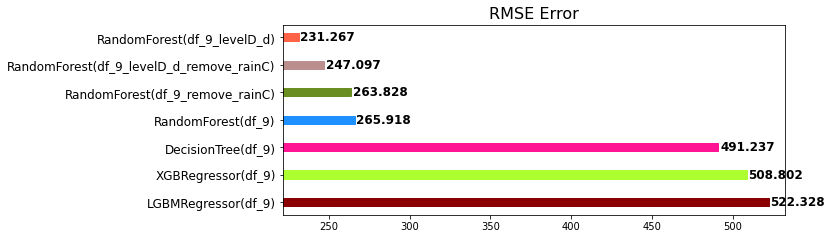

In [ ]:
rf_d_C=RandomForestRegressor(random_state=30)
param_grid = {"n_estimators": [200, 300, 500],
              "max_features": [4,9,16],
              "min_samples_leaf": [6, 8, 10]}

gs=GridSearchCV(RandomForestRegressor(random_state=30),param_grid=param_grid,cv=gkf.split(X,y, groups=event),n_jobs=-1,scoring="neg_root_mean_squared_error")
gs.fit(X,y)
rf_d_C=gs.best_estimator_
print("best parameter :",gs.best_estimator_)

rf_d_C.fit(x_train, y_train)
pred3 = rf_d_C.predict(x_test)
rmse_eval('RandomForest(df_9_levelD_d_remove_rainC)', pred3, y_test)

### 6. Predicting the 26th Event <a id=19></a>
[back to top](#20)

In [ ]:
# 데이터 불러오기
raw_26_d['target'] = np.nan
raw_26_d

,event,year,month,day,time,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
17346,26,2018,7,1,6,NaN,데이터집단 1,-0.903765,-0.640924,-1.015825,-0.864010,-0.950983,-1.122270,0.0
17347,26,2018,7,1,6,NaN,데이터집단 2,-0.968213,-0.674989,-1.009351,-0.862639,-0.950983,-1.122270,0.0
17348,26,2018,7,1,6,NaN,데이터집단 3,-0.968213,-0.674989,-0.959722,-0.868178,-0.957838,-1.122270,0.0
17349,26,2018,7,1,6,NaN,데이터집단 4,-1.029429,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0
17350,26,2018,7,1,6,NaN,데이터집단 5,-1.130231,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18301,26,2018,7,7,21,NaN,데이터집단 2,-1.113224,-1.100140,-1.009351,-0.862639,-0.950983,-0.616979,0.0
18302,26,2018,7,7,21,NaN,데이터집단 3,-1.113224,-1.100140,-0.959722,-0.868178,-0.957838,-0.616979,0.0
18303,26,2018,7,7,21,NaN,데이터집단 4,-1.122255,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0
18304,26,2018,7,7,21,NaN,데이터집단 5,-1.109680,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0


In [ ]:
# 유입량 예측치 생성
x_test_d=raw_26_d.drop("target",axis=1).drop('event',axis=1).drop('group',axis=1).drop('month',axis=1).drop('day',axis=1).drop('time',axis=1).drop('year',axis=1)
x_test_d


,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d
17346,-0.903765,-0.640924,-1.015825,-0.864010,-0.950983,-1.122270,0.0
17347,-0.968213,-0.674989,-1.009351,-0.862639,-0.950983,-1.122270,0.0
17348,-0.968213,-0.674989,-0.959722,-0.868178,-0.957838,-1.122270,0.0
17349,-1.029429,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0
17350,-1.130231,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0
...,...,...,...,...,...,...,...
18301,-1.113224,-1.100140,-1.009351,-0.862639,-0.950983,-0.616979,0.0
18302,-1.113224,-1.100140,-0.959722,-0.868178,-0.957838,-0.616979,0.0
18303,-1.122255,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0
18304,-1.109680,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0


In [ ]:
raw_26_d["target"] = rf_d.predict(x_test_d)
raw_26_d = raw_26_d.rename(columns={'time':'hour'})

In [ ]:
raw_26_d['date'] = pd.to_datetime(raw_26_d[['year','month','day','hour']],format='%Y-%m-%d %H:%M')

In [ ]:
raw_26_d

,event,year,month,day,hour,target,group,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d,date
17346,26,2018,7,1,6,119.335723,데이터집단 1,-0.903765,-0.640924,-1.015825,-0.864010,-0.950983,-1.122270,0.0,2018-07-01 06:00:00
17347,26,2018,7,1,6,114.517429,데이터집단 2,-0.968213,-0.674989,-1.009351,-0.862639,-0.950983,-1.122270,0.0,2018-07-01 06:00:00
17348,26,2018,7,1,6,114.420715,데이터집단 3,-0.968213,-0.674989,-0.959722,-0.868178,-0.957838,-1.122270,0.0,2018-07-01 06:00:00
17349,26,2018,7,1,6,120.517108,데이터집단 4,-1.029429,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0,2018-07-01 06:00:00
17350,26,2018,7,1,6,83.785065,데이터집단 5,-1.130231,-0.691836,-0.959722,-0.961952,-0.980372,-1.122270,0.0,2018-07-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18301,26,2018,7,7,21,432.877672,데이터집단 2,-1.113224,-1.100140,-1.009351,-0.862639,-0.950983,-0.616979,0.0,2018-07-07 21:00:00
18302,26,2018,7,7,21,436.058891,데이터집단 3,-1.113224,-1.100140,-0.959722,-0.868178,-0.957838,-0.616979,0.0,2018-07-07 21:00:00
18303,26,2018,7,7,21,437.201748,데이터집단 4,-1.122255,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0,2018-07-07 21:00:00
18304,26,2018,7,7,21,438.476662,데이터집단 5,-1.109680,-1.114051,-0.959722,-0.961952,-0.980372,-0.616979,0.0,2018-07-07 21:00:00


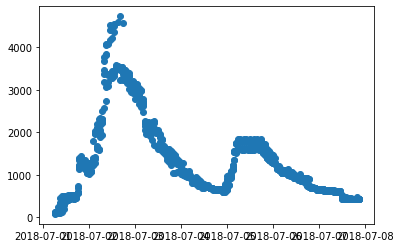

In [ ]:
# 유입량 그래프 그리기
plt.scatter(raw_26_d['date'],raw_26_d['target'] )

In [ ]:
raw_26_d = raw_26_d.groupby(['year','month','day','hour']).mean().reset_index() # 데이터집단별 target을 1개의 값으로 평균
raw_26_d['date'] = pd.to_datetime(raw_26_d[['year','month','day','hour']],format='%Y-%m-%d %H:%M')
raw_26_d 

,year,month,day,hour,event,target,avg_rain,rainA,rainB,rainC,rainD,levelE,levelD_d,date
0,2018,7,1,6,26,110.429074,-1.014971,-0.677735,-0.978589,-0.894339,-0.963968,-1.122270,0.000000,2018-07-01 06:00:00
1,2018,7,1,7,26,114.177236,-1.018281,-0.835333,-0.962145,-0.763063,-0.893089,-1.122270,0.000000,2018-07-01 07:00:00
2,2018,7,1,8,26,138.250174,-0.964166,-0.892778,-0.896370,-0.708905,-0.751330,-1.122270,0.000000,2018-07-01 08:00:00
3,2018,7,1,9,26,251.196365,-0.874940,-0.927190,-0.797707,-0.627279,-0.647923,-1.122270,0.000000,2018-07-01 09:00:00
4,2018,7,1,10,26,302.866217,-0.761815,-0.888393,-0.567494,-0.547597,-0.526656,-1.122270,0.000000,2018-07-01 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2018,7,7,17,26,443.294041,-1.104299,-1.102455,-0.978589,-0.898065,-0.963968,-0.574872,0.002750,2018-07-07 17:00:00
156,2018,7,7,18,26,439.085673,-1.104598,-1.102455,-0.978589,-0.898065,-0.963968,-0.574872,0.000000,2018-07-07 18:00:00
157,2018,7,7,19,26,436.798356,-1.104897,-1.102455,-0.978589,-0.898065,-0.963968,-0.616979,0.000000,2018-07-07 19:00:00
158,2018,7,7,20,26,443.398111,-1.105482,-1.102455,-0.978589,-0.898065,-0.963968,-0.616979,0.002753,2018-07-07 20:00:00


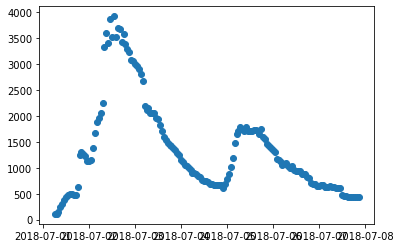

In [ ]:
plt.scatter(raw_26_d['date'],raw_26_d['target'] )

In [ ]:
# 파일로 추출

In [ ]:
final=pd.read_excel('/content/drive/MyDrive/빅콘테스트/data set/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx')

In [ ]:
final = final.drop(0,0)

In [ ]:
final['유입량'][:] = raw_26_d['target'][0:]

In [ ]:
final 

,NO,홍수사상번호,연,월,일,시간,유입량
1,1.0,26.0,2018.0,7.0,1.0,6.0,110.429074
2,2.0,26.0,2018.0,7.0,1.0,7.0,114.177236
3,3.0,26.0,2018.0,7.0,1.0,8.0,138.250174
4,4.0,26.0,2018.0,7.0,1.0,9.0,251.196365
5,5.0,26.0,2018.0,7.0,1.0,10.0,302.866217
...,...,...,...,...,...,...,...
156,156.0,26.0,2018.0,7.0,7.0,17.0,443.294041
157,157.0,26.0,2018.0,7.0,7.0,18.0,439.085673
158,158.0,26.0,2018.0,7.0,7.0,19.0,436.798356
159,159.0,26.0,2018.0,7.0,7.0,20.0,443.398111


In [ ]:
final.to_excel(excel_writer='/content/drive/MyDrive/빅콘테스트/data set/데이터분석분야_홍수ZERO_옥수수_평가데이터_210914.xlsx') #최종 excel file 추출